# Train a deep CNN on XPS data on Google Colab

In this notebook, we will train a deep convolutional network on iron XPS spectra made up of linear combinations of single iron reference spectra.

## Setup

### Mount google drive, change working directory

In [1]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Change working path
os.chdir('/content/drive/My Drive/deepxps')

Mounted at /content/drive


### Install packages and import modules

In [2]:
%%capture
# Install packages
!pip install python-docx
!pip install tensorflow==2.3.0 as tf

# Import standard modules and magic commands
import datetime
import numpy as np
import pytz
import importlib

# Magic commands
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

### Check TensorFlow version

In [3]:
tf.__version__

'2.3.0'

### Check TPU connection

In [24]:
from tensorflow.python.profiler import profiler_client

tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
print(profiler_client.monitor(tpu_profile_service_address, 100, 2))

  Timestamp: 08:47:16
  TPU type: TPU v2
  Utilization of TPU Matrix Units (higher is better): 0.000%




## Initial training

### Load custom modules

In [4]:
try:
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('Modules were loaded.')

Modules were loaded.


### Set up the parameters & folder structure



In [5]:
np.random.seed(502)
time = datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
data_name = 'Fe_4_classes_linear_comb_new_noise_small_resnet'
label_values = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']
#label_values = ['Pd metal', 'PdO']

clf = classifier.ClassifierMultiple(time = time,
                                    data_name = data_name,
                                    labels = label_values)

Model folder created at /saved_models/20210218_09h21m_Fe_4_classes_linear_comb_new_noise_small_resnet
Logs folder created at /logs/20210218_09h21m_Fe_4_classes_linear_comb_new_noise_small_resnet
Figures folder created at /figures/20210218_09h21m_Fe_4_classes_linear_comb_new_noise_small_resnet


### Load and inspect the data

Data was loaded!
Total no. of samples: 100000
No. of training samples: 64000
No. of validation samples: 16000
No. of test samples: 20000
Shape of each sample : 1121 features (X) + 4 labels (y)


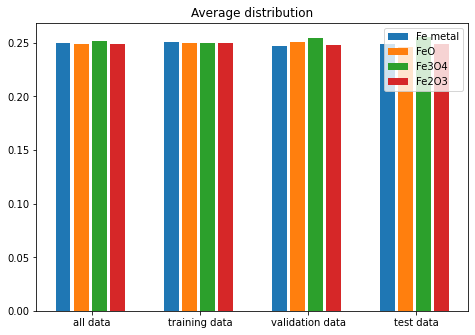

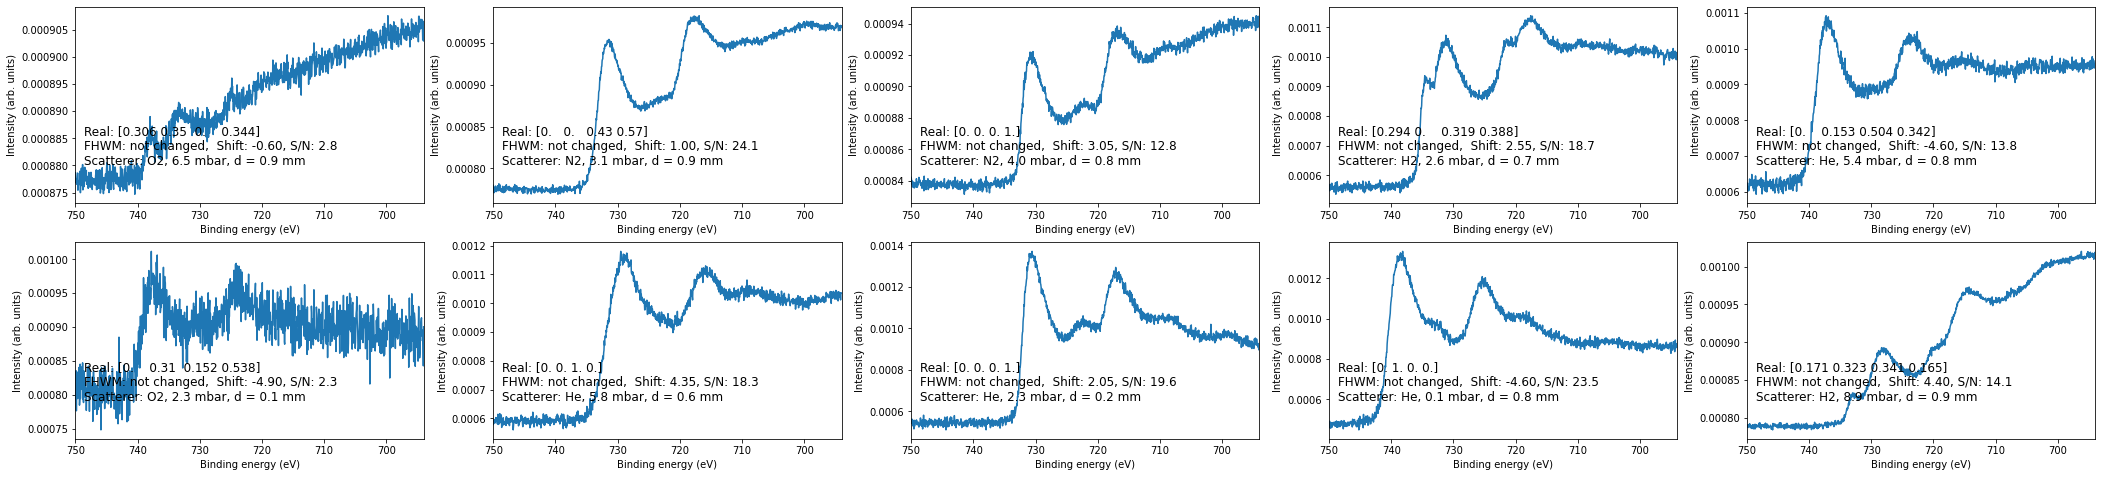

In [6]:
input_filepath = r'/content/drive/My Drive/deepxps/datasets/20201612_iron_variable_linear_combination_gas_phase_combined_data.h5'
train_test_split = 0.2
train_val_split = 0.2
no_of_examples = 100000

X_train, X_val, X_test, y_train, y_val, y_test,\
    aug_values_train, aug_values_val, aug_values_test =\
        clf.load_data_preprocess(input_filepath = input_filepath,
                                 no_of_examples = no_of_examples,
                                 train_test_split = train_test_split,
                                 train_val_split = train_val_split)
               
# Check how the examples are distributed across the classes.
class_distribution = clf.check_class_distribution()
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 10, dataset = 'train')  

### Design the model

In [9]:
try:
    importlib.reload(models)
    print('Models module was reloaded.')
except:
    import xpsdeeplearning.network.models as models
    print('Models module was loaded.')

<module 'xpsdeeplearning.network.models' from '/content/drive/My Drive/deepxps/xpsdeeplearning/network/models.py'>

Models module was reloaded.


In [ ]:
# =============================================================================
# import tensorflow as tf
# from tensorflow.keras import layers
# from tensorflow.keras.initializers import glorot_uniform
# from tensorflow.python.keras import backend as K
# 
# class CustomCNNMultiple(models.EmptyModel):
#     """
#     A CNN with three convolutional layers of different kernel size at 
#     the beginning. Works well for learning across scales.
#     
#     This is to be used for regression on all labels. -> sigmoid 
#     activation in the last layer.
#     """
#     def __init__(self, inputshape, num_classes):      
#         self.input_1 = layers.Input(shape = inputshape)
#         
#         self.conv_1_short = layers.Conv1D(filters=12,
#                                           kernel_size=5,
#                                           strides=1,
#                                           padding='same',
#                                           activation='relu',
#                                           name='conv_1_short')(self.input_1)
#         self.conv_1_medium = layers.Conv1D(filters=12,
#                                            kernel_size=10,
#                                            strides=1,
#                                            padding='same',
#                                            activation='relu',
#                                            name='conv_1_medium')(self.input_1)
#         self.conv_1_long = layers.Conv1D(filters=12,
#                                          kernel_size=10,
#                                          strides=1,
#                                          padding='same',
#                                          activation='relu',
#                                          name='conv_1_long')(self.input_1)
#         
#         sublayers = [self.conv_1_short, self.conv_1_medium, self.conv_1_long]
#         merged_sublayers = layers.concatenate(sublayers)
# 
#         self.conv_2 = layers.Conv1D(filters=10,
#                                     kernel_size=5,
#                                     strides=1,
#                                     padding='same',
#                                     activation='relu',
#                                     name='conv_2')(merged_sublayers)
#         self.conv_3 = layers.Conv1D(filters=10,
#                                     kernel_size=5,
#                                     strides=1,
#                                     padding='same',
#                                     activation='relu',
#                                     name="conv_3")(self.conv_2)
#         self.average_pool_1 = layers.AveragePooling1D(
#             name='average_pool_1')(self.conv_3)
#         
#         self.flatten_1 = layers.Flatten(name='flatten1')(self.average_pool_1)
#         self.drop_1 = layers.Dropout(rate=0.2,
#                                      name='drop_1')(self.flatten_1)
#         self.dense_1 = layers.Dense(units=4000,
#                                     activation='relu',
#                                     name='dense_1')(self.drop_1)
#         self.dense_2 = layers.Dense(units=num_classes,
#                                     activation='sigmoid',
#                                     name='dense_2')(self.dense_1)
#         
#         self.output_norm = layers.Lambda(
#             lambda x: x/tf.reshape(K.sum(x, axis=-1),(-1,1)),
#             name = 'output_normalization')(self.dense_2)
# 
#         no_of_inputs = len(sublayers)
# 
#         super(CustomCNNMultiple, self).__init__(inputs=self.input_1,
#                                                 outputs=self.output_norm,
#                                                 inputshape=inputshape,
#                                                 num_classes=num_classes,
#                                                 no_of_inputs=no_of_inputs,
#                                                 name='Custom_CNN_multiple') 
# =============================================================================

In [20]:
from tensorflow.keras import layers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.python.keras import backend as K


class ResNet1D(models.EmptyModel):
    """
    Instantiates the ResNet50 architecture in 1D similar to the original 
    ResNet paper. Using the functional API in Keras.
    
    Implementation of the popular ResNet50 the following architecture:
    CONV1D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 ->
    CONVBLOCK -> IDBLOCK*3 -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> 
    IDBLOCK*2 -> AVGPOOL (optional) -> OUTPUTLAYER
    """
    def __init__(self,
                 inputshape,
                 num_classes,
                 ap=False,
                 no_of_inputs=1):
        """
        Parameters
        ----------
        num_classes : int
            Number of output classes.
        ap : bool, optional
            If ap, then an AveragePooling1D layer is added after the
            residual blocks. The default is False.
        no_of_inputs : int, optional
            Number of input layers. The default is 1.
            (not working here)

        Returns
        -------
        None.

        """
        self.ap = ap
        
        self.input_1 = layers.Input(shape=inputshape,
                                    name='input_1')
    
        # Zero-Padding
        self.zero_pad_1 = layers.ZeroPadding1D(padding=3)(self.input_1)
        
        # Stage 1
        self.conv_1 = layers.Conv1D(filters=64,
                                    kernel_size=2,
                                    padding='valid',
                                    kernel_initializer=glorot_uniform(seed=0),
                                    name='stage1_conv')(self.zero_pad_1)
        self.batch_1 = layers.BatchNormalization(
            axis=1,
            name='stage1_bn')(self.conv_1)
        self.act_1 = layers.Activation(
            activation='relu',
            name='stage1_act')(self.batch_1)
        self.max_pool_1 = layers.MaxPooling1D(
            pool_size=1,
            strides=1,
            name='stage1_max_pool')(self.act_1)
        
        # Stage 2
        self.conv_block_2a = models.ConvBlock(filters=[32,32,128],
                                       kernel_size_2=4,
                                       stage=2,
                                       block='a')(self.max_pool_1)
        self.id_block_2b = models.IdentityBlock(filters=[32,32,128],
                                         kernel_size_2=1,
                                         stage=2,
                                         block='b')(self.conv_block_2a)
        self.id_block_2c = models.IdentityBlock(filters=[32,32,128],
                                         kernel_size_2=1,
                                         stage=2,
                                         block='c')(self.id_block_2b)

        # Stage 3
        self.conv_block_3a = models.ConvBlock(filters=[64,64,256],
                                       kernel_size_2=3,
                                       stage=3,
                                       block='a')(self.id_block_2c)
        self.id_block_3b = models.IdentityBlock(filters=[64,64,256],
                                         kernel_size_2=3,
                                         stage=3,
                                         block='b')(self.conv_block_3a)
        self.id_block_3c = models.IdentityBlock(filters=[64,64,256],
                                         kernel_size_2=3,
                                         stage=3,
                                         block='c')(self.id_block_3b)
        self.id_block_3d = models.IdentityBlock(filters=[64,64,256],
                                         kernel_size_2=3,
                                         stage=3,
                                         block='d')(self.id_block_3c)
        
# =============================================================================
#         # Stage 4
#         self.conv_block_4a = models.ConvBlock(filters=[128,128,1024],
#                                        kernel_size_2=3,
#                                        stage=4,
#                                        block='a')(self.id_block_3d)
#         self.id_block_4b = models.IdentityBlock(filters=[128,128,1024],
#                                          kernel_size_2=3,
#                                          stage=4,
#                                          block='b')(self.conv_block_4a)
#         self.id_block_4c = models.IdentityBlock(filters=[128,128,1024],
#                                          kernel_size_2=3,
#                                          stage=4,
#                                           block='c')(self.id_block_4b)
#         self.id_block_4d = models.IdentityBlock(filters=[128,128,1024],
#                                          kernel_size_2=3,
#                                          stage=4,
#                                          block='d')(self.id_block_4c)
#         self.id_block_4e = models.IdentityBlock(filters=[128,128,1024],
#                                          kernel_size_2=3,
#                                          stage=4,
#                                          block='e')(self.id_block_4d)
#         self.id_block_4f = models.IdentityBlock(filters=[128,128,1024],
#                                          kernel_size_2=3,
#                                          stage=4,
#                                          block='f')(self.id_block_4e)
# 
#         # Stage 5
#         self.conv_block_5a = models.ConvBlock(filters=[256,56,1024],
#                                        kernel_size_2=1,
#                                        stage=5,
#                                        block='a')(self.id_block_4f)
#         self.id_block_5b = models.IdentityBlock(filters=[256,56,1024],
#                                          kernel_size_2=1,
#                                          stage=5,
#                                          block='b')(self.conv_block_5a)
#         self.id_block_5c = models.IdentityBlock(filters=[256,56,1024],
#                                          kernel_size_2=1,
#                                          stage=5,
#                                          block='c')(self.id_block_5b)
# =============================================================================

        # Average pooling
        if self.ap:
            self.avg_pool = layers.AveragePooling1D(
                pool_size=3,
                name='avg_pool')(self.id_block_3d)
            self.flatten = layers.Flatten(name='flatten')(self.avg_pool)
        
        else:
            self.flatten = layers.Flatten(name='flatten')(self.id_block_3d)

        # output layer
        self.dense = layers.Dense(units=num_classes,
                                  activation='sigmoid',
                                  kernel_initializer = glorot_uniform(seed=0),
                                  name='dense')(self.flatten)
        
        # output norm
        self.output_norm = layers.Lambda(
            lambda x: x/tf.reshape(K.sum(x, axis=-1),(-1,1)),
            name = 'output_norm')(self.dense)
        
        super(ResNet1D, self).__init__(inputs=self.input_1,
                                        outputs=self.output_norm,
                                        inputshape=inputshape,
                                        num_classes=num_classes,
                                        no_of_inputs=no_of_inputs, 
                                        name ='ResNet1D')

### Build the model

In [21]:
#clf.model = CustomCNNMultiple(clf.input_shape, clf.num_classes)
clf.model = ResNet1D(clf.input_shape,
                     clf.num_classes,
                     ap=True)
# Alternative: Build model from available models
#clf.model = models.CustomCNNMultiple(clf.input_shape, clf.num_classes)
# =============================================================================
# clf.model = models.ResNet1D(clf.input_shape,
#                             clf.num_classes,
#                             ap=True)
# =============================================================================

### Compile and summarize the model

Model: "ResNet1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1121, 1)]         0         
_________________________________________________________________
zero_padding1d_3 (ZeroPaddin (None, 1127, 1)           0         
_________________________________________________________________
stage1_conv (Conv1D)         (None, 1126, 64)          192       
_________________________________________________________________
stage1_bn (BatchNormalizatio (None, 1126, 64)          4504      
_________________________________________________________________
stage1_act (Activation)      (None, 1126, 64)          0         
_________________________________________________________________
stage1_max_pool (MaxPooling1 (None, 1126, 64)          0         
_________________________________________________________________
2a_CONV (ConvBlock)          (None, 563, 128)          400

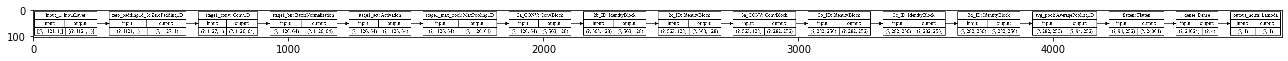

In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

learning_rate = 1e-05
optimizer = Adam(learning_rate = learning_rate) 
mse = MeanSquaredError()
mae = MeanAbsoluteError()

# =============================================================================
# def custom_loss(y_true, y_pred):
#     """
#     Custom loss for linear combination of XPS spectra.
#     """
#     squared_difference = tf.square(tf.subtract(y_true,y_pred))
#     squared_output = tf.square(y_pred)
#     
#     return tf.reduce_sum(tf.multiply(squared_output,squared_difference))
# =============================================================================

# Compile model with build-in loss function
#clf.model.compile(loss = mse, optimizer = optimizer)
clf.model.compile(loss = mae, optimizer = optimizer)

# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

### Show initial predictions

In [23]:
pred_train_initial, pred_test_initial = clf.predict()

print(y_train[:5])
print(pred_train_initial[:5])

print(y_test[:5])
print(pred_test_initial[:5])

625/625 [==============================] - 120s 192ms/step
Prediction done!
[[0.31205269 0.         0.40219418 0.28575314]
 [0.12012802 0.         0.64959689 0.23027508]
 [0.         0.         0.         1.        ]
 [0.17037062 0.40927964 0.42034974 0.        ]
 [0.10994057 0.11133631 0.38699865 0.39172448]]
[[0.2500146  0.24999419 0.24999659 0.24999467]
 [0.25001356 0.24999492 0.24999811 0.24999347]
 [0.25001305 0.24999444 0.24999847 0.249994  ]
 [0.25001267 0.24999493 0.24999909 0.24999331]
 [0.25001338 0.24999389 0.24999847 0.2499943 ]]
[[0.4027568  0.         0.         0.5972432 ]
 [0.         0.37062587 0.28070385 0.34867028]
 [0.38762291 0.61237709 0.         0.        ]
 [0.42268984 0.         0.37797207 0.19933809]
 [0.         0.         0.71474035 0.28525965]]
[[0.2500137  0.24999382 0.24999733 0.24999511]
 [0.25001281 0.24999453 0.249999   0.24999365]
 [0.25001207 0.24999498 0.24999978 0.24999315]
 [0.250013   0.24999486 0.24999858 0.24999356]
 [0.25001302 0.24999598 0.24

### Train

In [ ]:
epochs = 1000
batch_size = 32

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 epochs = epochs, 
                 batch_size = batch_size,
                 verbose = 1)

Epoch 1/1000
2000/2000 [==============================] - 11350s 6s/step - loss: 0.2246 - val_loss: 0.2256
Epoch 2/1000
2000/2000 [==============================] - 11560s 6s/step - loss: 0.2245 - val_loss: 0.2256
Epoch 3/1000
2000/2000 [==============================] - 10951s 5s/step - loss: 0.2245 - val_loss: 0.2256
Epoch 4/1000
1309/2000 [==================>...........] - ETA: 58:40 - loss: 0.2245

### Plot loss

In [ ]:
dir_name = clf.time + '_' + clf.data_name
graph = clfutils.TrainingGraphs(clf.history, dir_name)
graph.plot_loss()

### Evaluate on test data

In [ ]:
test_loss = clf.evaluate()
print('Test loss: ' + str(test_loss))

###  Predict on train and test data

In [ ]:
pred_train, pred_test = clf.predict()

### Show some predictions

#### 10 random training samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'train', with_prediction = True)  

#### 10 random test samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'test', with_prediction = True)  

### Show worst predictions

In [ ]:
clf.show_worst_predictions(no_of_spectra = 20)  

### Save model and data

In [ ]:
#clf.save_model()
clf.save_hyperparams()
clf.shelve_results(full = False)

### Generate report

In [ ]:
dir_name = clf.time + '_' + clf.data_name
rep = clfutils.Report(dir_name)  
rep.write()   

## Continue training

### Load custom modules

In [ ]:
try:
    import importlib
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('\n Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('\n Modules were loaded.')


 Modules were loaded.


### Set up the parameters & folder structure

In [ ]:
np.random.seed(502)
time = '20210214_11h58m'
data_name = 'Fe_4_classes_linear_comb_new_noise_resnet'

label_values = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']
#label_values = ['Pd metal', 'PdO']
clf = classifier.ClassifierMultiple(time = time,
                                    data_name = data_name,
                                    labels = label_values)

Model folder was already at /saved_models/20210214_11h58m_Fe_4_classes_linear_comb_new_noise_resnet
Logs folder was already at /logs/20210214_11h58m_Fe_4_classes_linear_comb_new_noise_resnet
Figures folder was already at /figures/20210214_11h58m_Fe_4_classes_linear_comb_new_noise_resnet


### Load and inspect the data

Data was loaded!
Total no. of samples: 100000
No. of training samples: 64000
No. of validation samples: 16000
No. of test samples: 20000
Shape of each sample : 1121 features (X) + 4 labels (y)


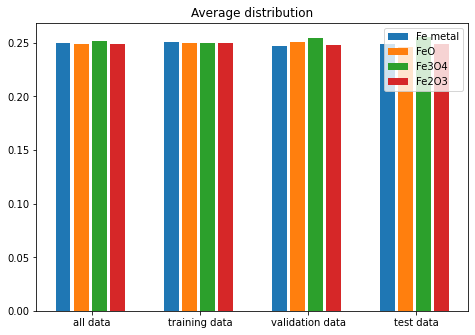

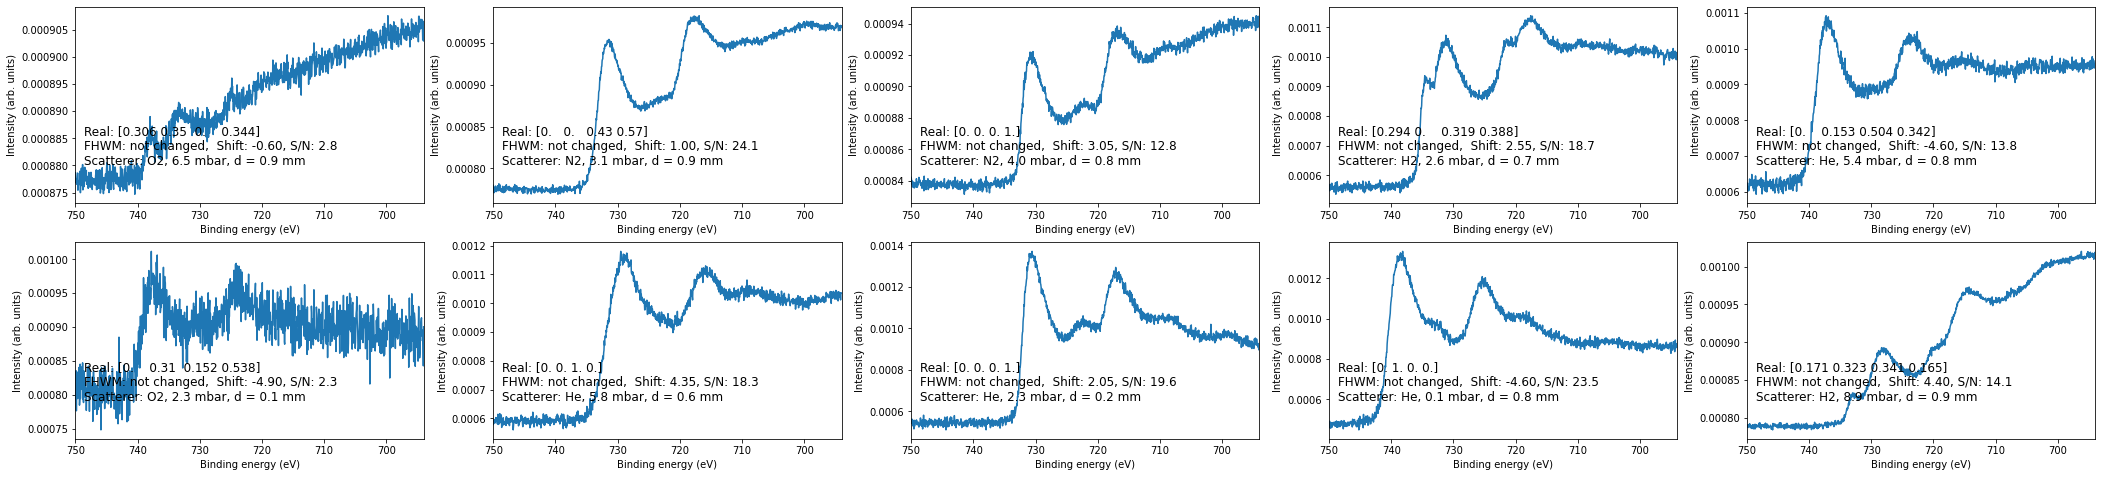

In [ ]:
input_filepath = r'/content/drive/My Drive/deepxps/datasets/20201612_iron_variable_linear_combination_gas_phase_combined_data.h5'
train_test_split = 0.2
train_val_split = 0.2
no_of_examples = 100000

X_train, X_val, X_test, y_train, y_val, y_test,\
    aug_values_train, aug_values_val, aug_values_test =\
        clf.load_data_preprocess(input_filepath = input_filepath,
                                 no_of_examples = no_of_examples,
                                 train_test_split = train_test_split,
                                 train_val_split = train_val_split)
                
# Check how the examples are distributed across the classes.
class_distribution = clf.check_class_distribution()
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 10, dataset = 'train')  

### Load the model

In [ ]:
clf.load_model()

Loaded model from disk.


### Compile and summarize the model

Model: "Loaded_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1121, 1)]         0         
_________________________________________________________________
zero_padding1d (ZeroPadding1 (None, 1127, 1)           0         
_________________________________________________________________
stage1_conv (Conv1D)         (None, 1126, 64)          192       
_________________________________________________________________
stage1_bn (BatchNormalizatio (None, 1126, 64)          4504      
_________________________________________________________________
stage1_act (Activation)      (None, 1126, 64)          0         
_________________________________________________________________
stage1_max_pool (MaxPooling1 (None, 1126, 64)          0         
_________________________________________________________________
2a_CONV (ConvBlock)          (None, 563, 128)         

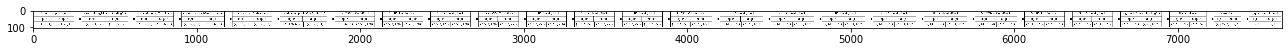

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

learning_rate = 1e-05
optimizer = Adam(learning_rate = learning_rate) 
mse = MeanSquaredError()
mae = MeanAbsoluteError()
# =============================================================================
# def custom_loss(y_true, y_pred):
#     """
#     Custom loss for linear combination of XPS spectra.
#     """
#     squared_difference = tf.square(tf.subtract(y_true,y_pred))
#     squared_output = tf.square(y_pred)
#     
#     return tf.reduce_sum(tf.multiply(squared_output,squared_difference))
# =============================================================================

# Compile model with build-in loss function
#clf.model.compile(loss = mse, optimizer = optimizer)
clf.model.compile(loss = mae, optimizer = optimizer)

# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

### Show predictions with current model

In [ ]:
pred_train_intermediate, pred_test_intermediate = clf.predict()

print(y_train[:5])
print(pred_train_intermediate[:5])

print(y_test[:5])
print(pred_test_intermediate[:5])

### Train

In [ ]:
epochs = 200
batch_size = 32

# =============================================================================
# hist = clf.train(checkpoint = True,
#                  early_stopping = False,
#                  tb_log = True, 
#                  csv_log = True,
#                  epochs = epochs, 
#                  batch_size = batch_size,
#                  verbose = 1)
# =============================================================================

new_learning_rate = 5e-06

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 epochs = epochs, 
                 batch_size = batch_size,
                 verbose = 1)#, 
#                 new_learning_rate = new_learning_rate)

Epoch 13/212
2000/2000 [==============================] - 9871s 5s/step - loss: 0.2245 - val_loss: 0.2256
Epoch 14/212
2000/2000 [==============================] - 10038s 5s/step - loss: 0.2245 - val_loss: 0.2256
Epoch 15/212
2000/2000 [==============================] - 10118s 5s/step - loss: 0.2245 - val_loss: 0.2256
Epoch 16/212
1956/2000 [============================>.] - ETA: 3:27 - loss: 0.2246

In [ ]:
from tensorflow.keras import backend as K
print('New learning rate: ' +\
      str(K.eval(clf.model.optimizer.lr)))

### Plot loss

In [ ]:
dir_name = clf.time + '_' + clf.data_name
graph = clfutils.TrainingGraphs(clf.history, dir_name)
graph.plot_loss()

### Evaluate on test data

In [ ]:
test_loss = clf.evaluate()
print('Test loss: ' + str(test_loss))

###  Predict on train & test data

In [ ]:
pred_train, pred_test = clf.predict()

### Show some predictions

#### 10 random training samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'train', with_prediction = True)  

#### 10 random test samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'test', with_prediction = True)  

### Show worst predictions

In [ ]:
clf.show_worst_predictions(no_of_spectra = 20)  

### Save model and data

In [ ]:
#clf.save_model()
clf.save_hyperparams()
clf.shelve_results(full = False)

### Generate report

In [ ]:
dir_name = clf.time + '_' + clf.data_name
rep = clfutils.Report(dir_name)  
rep.write()   

## Save output of notebook

In [ ]:
from IPython.display import Javascript, display
from nbconvert import HTMLExporter

def save_notebook():
    display(Javascript("IPython.notebook.save_notebook()"),
            include=['application/javascript'])

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

import time
import os

time.sleep(20)
save_notebook()
print('Notebook saved!')
time.sleep(30)
current_file = '/content/drive/My Drive/app/xpsdeeplearning/train_multiple.ipynb'
output_file = os.path.join(clf.log_dir,'train_multiple_out.html')
output_HTML(current_file, output_file)
print('HTML file saved!')